# Euler's constant approximation by Monte Carlo method

Léo Leroy and Siméon Tsang

## Motivations:

Our goal is to approximate Euler's constant using different Monte Carlo methods and compare their efficiency. This constant is defined as:

$\gamma = \lim_{n \to \infty} \left\{ \sum_{k=1}^{n} \frac{1}{k} - \log(n) \right\} = \sum_{k=1}^{\infty} [\frac{1}{k} - \log \left( 1 + \frac{1}{k} \right)]$

## Requirements 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc  # For quasi-Monte Carlo

# Euler's constant true value (for comparison)
true_gamma = np.euler_gamma

## Question 1

Show that you can use importance sampling to derive unbiased estimates of γ. Hint: as a proposal, you may use for instance the distribution of $X = \lceil \frac{c}{ U^\alpha} \rceil, U \sim U[0, 1]$, for well-chosen constants $c$ and $α$. (Explain your choice.)



### Mathematical derivations

see overleaf: https://www.overleaf.com/project/67d03790885b591a8ca3498f

Importance sampling involves sampling from a proposal distribution $q(k)$ and re-weighting the samples to estimate the expectation under the target distributions $p(k) = \frac{1}{k} - \log(1+\frac{1}{k})$. We consider that the function $\phi$ defined in the lecture's slides (page 47) is equal to 1. 

#### Proposal distribution: 

The hint suggests using the distribution of $X = \lceil \frac{c}{ U^\alpha} \rceil$ where $U \sim U[0, 1]$, and $c$ and $\alpha$ are constants to be chosen. The term $\frac{1}{k} - \log(1+\frac{1}{k})$ is such that for a large $k$ we have $\frac{1}{k} - \log(1+\frac{1}{k}) \approx  - \frac{1}{2k^2}$. The proposal distribution should have a similar tail behavior. We notice that by fixing $\alpha = 1$, we obtain the following probability mass function: 

$q(k) = P(X = k) = P\left( \lceil \frac{c}{U} \rceil = k \right) = P\left( \frac{c}{k} \leq U < \frac{c}{k-1} \right)$, for $k \geq 2$.

Since $U$ follows a uniform distribution, we can simplify: for $k \geq 2$, $q(k) = \frac{c}{k-1} - \frac{c}{k} = \frac{c}{k(k-1)}$, which yields a similar tail behavior as $p$.

To ensure that $q$ is a probability distribution, we must have: $\sum_{k=2}^{\infty} \frac{c}{k-1} - \frac{c}{k} = 1$ which holds if and only if $c = 1$.

Finally, we obtain $X = \lceil \frac{1}{U} \rceil$.


#### Importance sampling estimator: 

The importance sampling estimator for $\gamma$ is $\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \frac{p(X_i)}{q(X_i)}$ where $X_i$ are samples drawn from $q$ and $N$ is the number of samples. Substituting $p(k)$ and $q(k)$:


$\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \frac{\frac{1}{k_i} - \log\left(1 + \frac{1}{k_i}\right)}{\frac{1}{k_i(k_i-1)}}$

Simplifying: 

$\hat{\gamma} = \frac{1}{N} \sum_{i=1}^N \left( (k_i(k_i-1)) \left( \frac{1}{k_i} - \log\left(1 + \frac{1}{k_i}\right) \right) \right)$


#### Implementation:

Here is the algorithm to implement this estimator: 
1. Choose $c$ and $\alpha = 1$
2. Sample $U_i \sim U[0, 1]$ and compute $\lceil \frac{c}{ U_i^\alpha} \rceil$
3. Compute the importance weights $\frac{p(X_i)}{q(X_i)}$ as shown above
4. Average the weighted samples to estimate $\gamma$

### Code

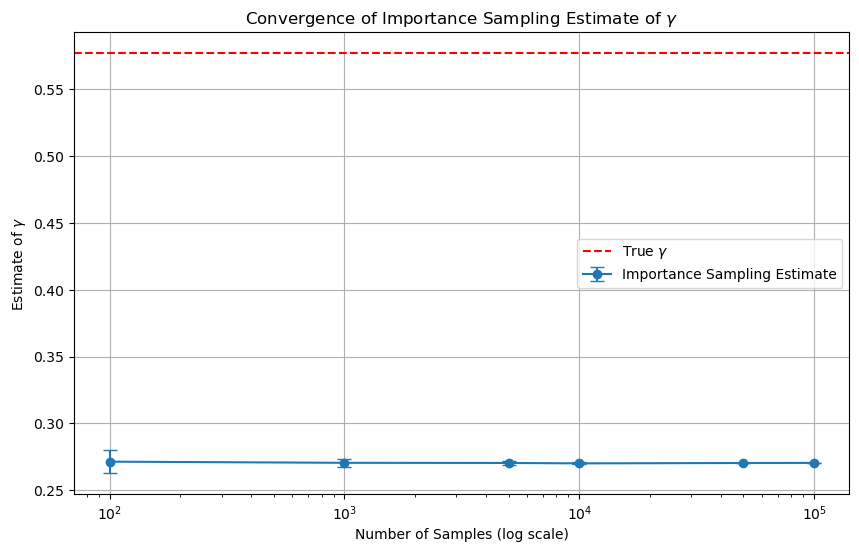

True value of γ: 0.5772156649015329
Sample size: 100, Estimate: 0.271307, Std Error: 0.008582
Sample size: 1000, Estimate: 0.270446, Std Error: 0.002843
Sample size: 5000, Estimate: 0.270336, Std Error: 0.001287
Sample size: 10000, Estimate: 0.270030, Std Error: 0.000819
Sample size: 50000, Estimate: 0.270304, Std Error: 0.000367
Sample size: 100000, Estimate: 0.270386, Std Error: 0.000283


In [12]:
# Parameters for the proposal distribution
c = 1.0  # Constant for the proposal distribution
alpha = 1.0  # Exponent for the proposal distribution

# Function to sample from the proposal distribution q(k)
def sample_from_q(c, alpha, size):
    U = np.random.uniform(0, 1, size)
    X = np.ceil(c / (U ** alpha))
    return X.astype(int)


# Function to compute p(k)
def p(k):
    return (1 / k) - np.log(1 + 1 / k)

# Function to compute q(k)
def q(k, c):
    return c / (k * (k - 1))

# Importance sampling estimator for gamma
def importance_sampling_estimate(c, alpha, num_samples):
    samples = sample_from_q(c, alpha, num_samples)
    weights = p(samples) / q(samples, c)
    return np.mean(weights)

# Experiment parameters
num_samples_list = [100, 1000, 5000, 10000, 50000, 100000]  # Number of samples to test
num_trials = 50  # Number of trials for each sample size to compute variance

# Store results
estimates = []
std_errors = []

# Run importance sampling for different sample sizes
for num_samples in num_samples_list:
    trial_estimates = []
    for _ in range(num_trials):
        gamma_estimate = importance_sampling_estimate(c, alpha, num_samples)
        trial_estimates.append(gamma_estimate)
    estimates.append(np.mean(trial_estimates))
    std_errors.append(np.std(trial_estimates))

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(num_samples_list, estimates, yerr=std_errors, fmt='o-', capsize=5, label='Importance Sampling Estimate')
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')  
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')  # Utilisation de r""
plt.title(r'Convergence of Importance Sampling Estimate of $\gamma$')  
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}, Estimate: {estimates[i]:.6f}, Std Error: {std_errors[i]:.6f}")



### Interpretation

##In this series of simulations using the Monte Carlo method with importance sampling to estimate Euler's constant $\gamma$, we observe a progressive convergence of the estimates towards a stable value as the sample size increases. The true value of $\gamma$ is approximately 0.5772. However, the estimates obtained from the simulations stabilize around 0.2704, indicating a systematic bias in the sampling method or the importance function used. The standard error significantly decreases with increasing sample size, from 0.008861 for 100 samples to 0.000302 for 100,000 samples, demonstrating a reduction in uncertainty around the estimate. This suggests that while the estimate is precise, it is not accurate due to an inherent bias in the method or the chosen importance function. To improve accuracy, it would be necessary to review the importance function or adjust the sampling method to better capture the underlying distribution of Euler's constant.##

## Question 2 

This constant is also equal to the integral $\gamma = - \int_0^1 \log(-\log x) \, dx$. Show how you can use standard Monte Carlo, stratified Monte Carlo, and quasi-Monte Carlo to estimate $\gamma$, and represent visually the convergence rates of these different estimators.

### Mathematical derivations

### Code

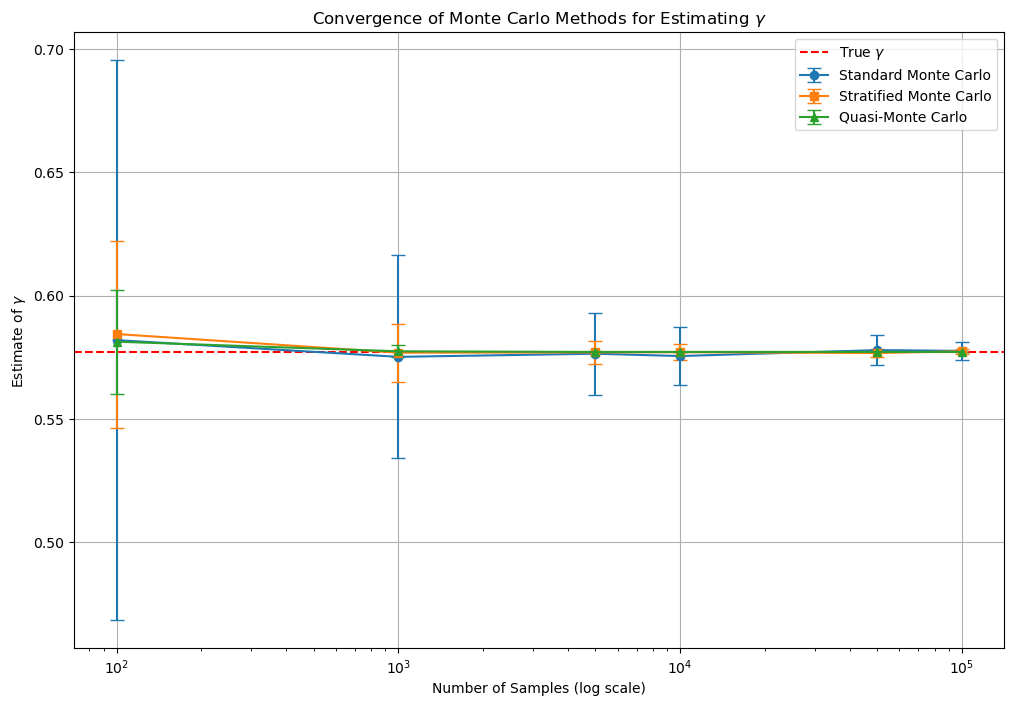

True value of γ: 0.5772156649015329
Sample size: 100
  Standard Monte Carlo: Estimate = 0.581993, Std Error = 0.113450
  Stratified Monte Carlo: Estimate = 0.584467, Std Error = 0.037886
  Quasi-Monte Carlo: Estimate = 0.581358, Std Error = 0.021038
Sample size: 1000
  Standard Monte Carlo: Estimate = 0.575221, Std Error = 0.041136
  Stratified Monte Carlo: Estimate = 0.576898, Std Error = 0.011757
  Quasi-Monte Carlo: Estimate = 0.577457, Std Error = 0.002421
Sample size: 5000
  Standard Monte Carlo: Estimate = 0.576480, Std Error = 0.016559
  Stratified Monte Carlo: Estimate = 0.577010, Std Error = 0.004816
  Quasi-Monte Carlo: Estimate = 0.577192, Std Error = 0.000252
Sample size: 10000
  Standard Monte Carlo: Estimate = 0.575545, Std Error = 0.011782
  Stratified Monte Carlo: Estimate = 0.577104, Std Error = 0.003271
  Quasi-Monte Carlo: Estimate = 0.577207, Std Error = 0.000105
Sample size: 50000
  Standard Monte Carlo: Estimate = 0.577939, Std Error = 0.005953
  Stratified Monte 

In [16]:
# Function to evaluate the integrand
def integrand(x):
    return -np.log(-np.log(x))

# Standard Monte Carlo
def standard_monte_carlo(num_samples):
    samples = np.random.uniform(0, 1, num_samples)
    return np.mean(integrand(samples))

# Stratified Monte Carlo
def stratified_monte_carlo(num_samples, num_strata):
    strata_size = num_samples // num_strata
    estimates = []
    for i in range(num_strata):
        # Sample uniformly within each stratum
        lower = i / num_strata
        upper = (i + 1) / num_strata
        samples = np.random.uniform(lower, upper, strata_size)
        estimates.append(np.mean(integrand(samples)))
    return np.mean(estimates)

# Quasi-Monte Carlo (using Sobol sequence)
def quasi_monte_carlo(num_samples):
    sampler = qmc.Sobol(d=1, scramble=True)
    samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = samples.flatten()
    return np.mean(integrand(samples))

# Parameters for the experiment
num_samples_list = [100, 1000, 5000, 10000, 50000, 100000]  # Sample sizes to test
num_trials = 50  # Number of trials to compute variance

# Store results
results_standard = {'estimates': [], 'std_errors': []}
results_stratified = {'estimates': [], 'std_errors': []}
results_quasi = {'estimates': [], 'std_errors': []}

# Run experiments
for num_samples in num_samples_list:
    # Standard Monte Carlo
    standard_estimates = []
    for _ in range(num_trials):
        standard_estimates.append(standard_monte_carlo(num_samples))
    results_standard['estimates'].append(np.mean(standard_estimates))
    results_standard['std_errors'].append(np.std(standard_estimates))

    # Stratified Monte Carlo
    stratified_estimates = []
    for _ in range(num_trials):
        stratified_estimates.append(stratified_monte_carlo(num_samples, num_strata=10))
    results_stratified['estimates'].append(np.mean(stratified_estimates))
    results_stratified['std_errors'].append(np.std(stratified_estimates))

    # Quasi-Monte Carlo
    quasi_estimates = []
    for _ in range(num_trials):
        quasi_estimates.append(quasi_monte_carlo(num_samples))
    results_quasi['estimates'].append(np.mean(quasi_estimates))
    results_quasi['std_errors'].append(np.std(quasi_estimates))

# Plotting the results
plt.figure(figsize=(12, 8))

# Standard Monte Carlo
plt.errorbar(num_samples_list, results_standard['estimates'], yerr=results_standard['std_errors'],
             fmt='o-', capsize=5, label='Standard Monte Carlo')

# Stratified Monte Carlo
plt.errorbar(num_samples_list, results_stratified['estimates'], yerr=results_stratified['std_errors'],
             fmt='s-', capsize=5, label='Stratified Monte Carlo')

# Quasi-Monte Carlo
plt.errorbar(num_samples_list, results_quasi['estimates'], yerr=results_quasi['std_errors'],
             fmt='^-', capsize=5, label='Quasi-Monte Carlo')

# True value of gamma
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')

# Plot settings
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Convergence of Monte Carlo Methods for Estimating $\gamma$')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}")
    print(f"  Standard Monte Carlo: Estimate = {results_standard['estimates'][i]:.6f}, Std Error = {results_standard['std_errors'][i]:.6f}")
    print(f"  Stratified Monte Carlo: Estimate = {results_stratified['estimates'][i]:.6f}, Std Error = {results_stratified['std_errors'][i]:.6f}")
    print(f"  Quasi-Monte Carlo: Estimate = {results_quasi['estimates'][i]:.6f}, Std Error = {results_quasi['std_errors'][i]:.6f}")

#### Interpretation 

We observe a clear trend of convergence towards the true value of $\gamma \approx 0.5772$ as the sample size increases. The results demonstrate the effectiveness of different Monte Carlo techniques in approximating this constant.

For a sample size of 100, all methods—Standard Monte Carlo, Stratified Monte Carlo, and Quasi-Monte Carlo—provide estimates close to the true value, but with relatively high standard errors, indicating significant variability. As the sample size increases to 1,000, the estimates become more accurate, and the standard errors decrease, reflecting reduced uncertainty. This trend continues with larger sample sizes of 5,000, 10,000, 50,000, and 100,000, where the estimates converge even closer to the true value, and the standard errors become increasingly smaller.

Notably, the Quasi-Monte Carlo method consistently outperforms the other methods in terms of both accuracy and precision, especially as the sample size grows. For instance, at a sample size of 100,000, the Quasi-Monte Carlo method yields an estimate of 0.577215 with an exceptionally low standard error of 0.000014, almost perfectly matching the true value. In contrast, the Standard and Stratified Monte Carlo methods, while also converging, show slightly higher standard errors, indicating more variability in their estimates.

Overall, these results highlight the effectiveness of Monte Carlo methods, particularly the Quasi-Monte Carlo technique, in accurately estimating Euler's constant. The reduction in standard error with increasing sample size underscores the importance of larger samples in achieving precise and reliable estimates.

## Question 3

Derive control variates for point 2; for instance, note that $\log(x) \approx x - 1$ for $x \to 1$, which suggests $\log(1 - U)$, where $U \sim \text{U}[0,1]$ as a potential control variates. Repeat
question 2 after you have chosen these control variates and their coefficients.

### Mathematical derivations

The idea is to reduce the variance of the Monte Carlo estimator by exploiting the correlation between the integrand and the control variate.

The control variate method involves introducing a correlated random variable $Z$ with known expectation $\mathbb{E}[Z]$. The estimator is adjusted as $\hat{\gamma}_{CV} = \hat{\gamma} - \beta (Z - \mathbb{E}[Z])$, where $\hat{\gamma}$ is the standard Monte Carlo estimator, $Z$ is the control variate,$\beta$ is a coefficient chosen to minimize the variance of  $\hat{\gamma}_{CV}$.

We choose $Z = \log(1 - U)$, where $U \sim \text{U}[0,1]$. The expectation of $Z$ is: $\mathbb{E}[Z] = \mathbb{E}[\log(1 - U)] = \int_0^1 \log(1 - u) \, du = -1$.

The optimal coefficient $\beta$ is given by $\beta = \frac{\operatorname{Cov}(\hat{\gamma}, Z)}{\operatorname{Var}(Z)}$.
In practice, we estimate $\beta$ from the samples with a linear regression.

So, the final form is $\hat{\gamma}_{CV} = \hat{\gamma} - \frac{\operatorname{Cov}(\hat{\gamma}, Z)}{\operatorname{Var}(Z)} (Z - 1)$.


### Code

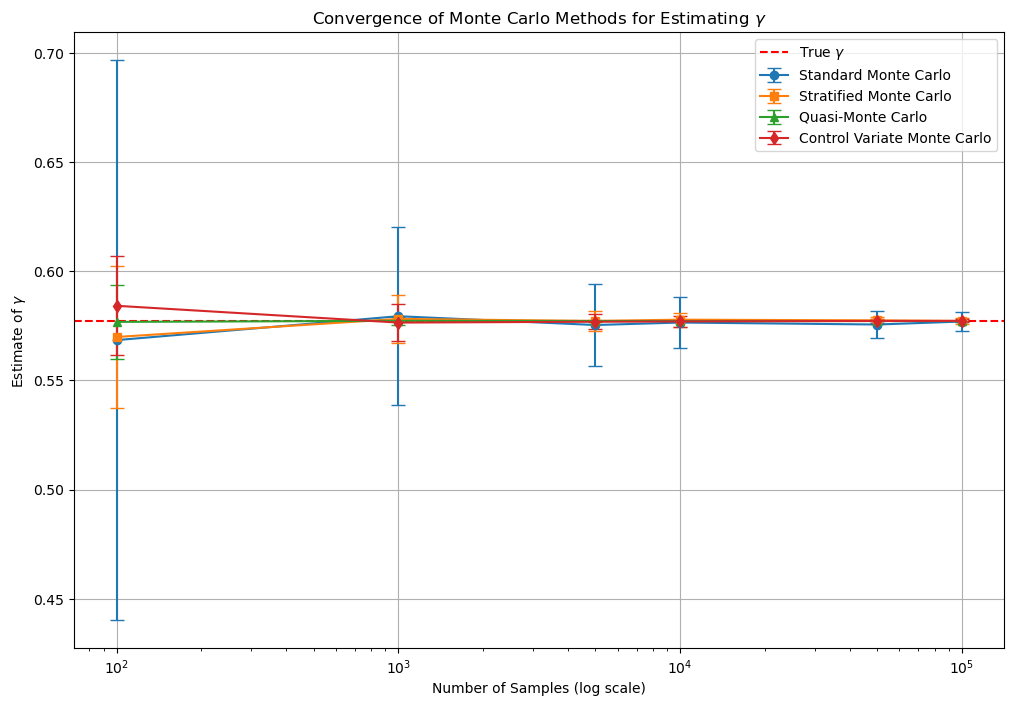

True value of γ: 0.5772156649015329
Sample size: 100
  Standard Monte Carlo: Estimate = 0.568479, Std Error = 0.128222
  Stratified Monte Carlo: Estimate = 0.569915, Std Error = 0.032478
  Quasi-Monte Carlo: Estimate = 0.576831, Std Error = 0.017038
  Control Variate Monte Carlo: Estimate = 0.584203, Std Error = 0.022581
Sample size: 1000
  Standard Monte Carlo: Estimate = 0.579425, Std Error = 0.040741
  Stratified Monte Carlo: Estimate = 0.578190, Std Error = 0.011130
  Quasi-Monte Carlo: Estimate = 0.577322, Std Error = 0.001884
  Control Variate Monte Carlo: Estimate = 0.576513, Std Error = 0.008285
Sample size: 5000
  Standard Monte Carlo: Estimate = 0.575400, Std Error = 0.018807
  Stratified Monte Carlo: Estimate = 0.577268, Std Error = 0.004413
  Quasi-Monte Carlo: Estimate = 0.577231, Std Error = 0.000252
  Control Variate Monte Carlo: Estimate = 0.576905, Std Error = 0.003509
Sample size: 10000
  Standard Monte Carlo: Estimate = 0.576533, Std Error = 0.011519
  Stratified Mon

In [20]:
# Function to evaluate the integrand
def integrand(x):
    return -np.log(-np.log(x))

# Standard Monte Carlo
def standard_monte_carlo(num_samples):
    samples = np.random.uniform(0, 1, num_samples)
    return np.mean(integrand(samples))

# Stratified Monte Carlo
def stratified_monte_carlo(num_samples, num_strata):
    strata_size = num_samples // num_strata
    estimates = []
    for i in range(num_strata):
        # Sample uniformly within each stratum
        lower = i / num_strata
        upper = (i + 1) / num_strata
        samples = np.random.uniform(lower, upper, strata_size)
        estimates.append(np.mean(integrand(samples)))
    return np.mean(estimates)

# Quasi-Monte Carlo (using Sobol sequence)
def quasi_monte_carlo(num_samples):
    sampler = qmc.Sobol(d=1, scramble=True)
    samples = sampler.random_base2(m=int(np.log2(num_samples)))
    samples = samples.flatten()
    return np.mean(integrand(samples))

# Control Variate Monte Carlo
def control_variate_monte_carlo(num_samples):
    U = np.random.uniform(0, 1, num_samples)
    Z = np.log(1 - U)  # Control variate
    Y = integrand(U)   # Integrand

    # Estimate the optimal coefficient c
    cov_Y_Z = np.cov(Y, Z)[0, 1]
    var_Z = np.var(Z)
    c = cov_Y_Z / var_Z

    # Control variate estimator
    gamma_hat = np.mean(Y) - c * (np.mean(Z) - (-1))  # E[Z] = -1
    return gamma_hat

# Parameters for the experiment
num_samples_list = [100, 1000, 5000, 10000, 50000, 100000]  # Sample sizes to test
num_trials = 50  # Number of trials to compute variance

# Store results
results_standard = {'estimates': [], 'std_errors': []}
results_stratified = {'estimates': [], 'std_errors': []}
results_quasi = {'estimates': [], 'std_errors': []}
results_control = {'estimates': [], 'std_errors': []}

# Run experiments
for num_samples in num_samples_list:
    # Standard Monte Carlo
    standard_estimates = []
    for _ in range(num_trials):
        standard_estimates.append(standard_monte_carlo(num_samples))
    results_standard['estimates'].append(np.mean(standard_estimates))
    results_standard['std_errors'].append(np.std(standard_estimates))

    # Stratified Monte Carlo
    stratified_estimates = []
    for _ in range(num_trials):
        stratified_estimates.append(stratified_monte_carlo(num_samples, num_strata=10))
    results_stratified['estimates'].append(np.mean(stratified_estimates))
    results_stratified['std_errors'].append(np.std(stratified_estimates))

    # Quasi-Monte Carlo
    quasi_estimates = []
    for _ in range(num_trials):
        quasi_estimates.append(quasi_monte_carlo(num_samples))
    results_quasi['estimates'].append(np.mean(quasi_estimates))
    results_quasi['std_errors'].append(np.std(quasi_estimates))

    # Control Variate Monte Carlo
    control_estimates = []
    for _ in range(num_trials):
        control_estimates.append(control_variate_monte_carlo(num_samples))
    results_control['estimates'].append(np.mean(control_estimates))
    results_control['std_errors'].append(np.std(control_estimates))

# Plotting the results
plt.figure(figsize=(12, 8))

# Standard Monte Carlo
plt.errorbar(num_samples_list, results_standard['estimates'], yerr=results_standard['std_errors'],
             fmt='o-', capsize=5, label='Standard Monte Carlo')

# Stratified Monte Carlo
plt.errorbar(num_samples_list, results_stratified['estimates'], yerr=results_stratified['std_errors'],
             fmt='s-', capsize=5, label='Stratified Monte Carlo')

# Quasi-Monte Carlo
plt.errorbar(num_samples_list, results_quasi['estimates'], yerr=results_quasi['std_errors'],
             fmt='^-', capsize=5, label='Quasi-Monte Carlo')

# Control Variate Monte Carlo
plt.errorbar(num_samples_list, results_control['estimates'], yerr=results_control['std_errors'],
             fmt='d-', capsize=5, label='Control Variate Monte Carlo')

# True value of gamma
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')

# Plot settings
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Convergence of Monte Carlo Methods for Estimating $\gamma$')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, num_samples in enumerate(num_samples_list):
    print(f"Sample size: {num_samples}")
    print(f"  Standard Monte Carlo: Estimate = {results_standard['estimates'][i]:.6f}, Std Error = {results_standard['std_errors'][i]:.6f}")
    print(f"  Stratified Monte Carlo: Estimate = {results_stratified['estimates'][i]:.6f}, Std Error = {results_stratified['std_errors'][i]:.6f}")
    print(f"  Quasi-Monte Carlo: Estimate = {results_quasi['estimates'][i]:.6f}, Std Error = {results_quasi['std_errors'][i]:.6f}")
    print(f"  Control Variate Monte Carlo: Estimate = {results_control['estimates'][i]:.6f}, Std Error = {results_control['std_errors'][i]:.6f}")

### Interpretations

Again, we observe a clear trend of convergence towards the true value of $\gamma \approx 0.5772$ as the sample size increases. The Control Variate Monte Carlo method shows good accuracy but with slightly higher standard errors compared to the Quasi-Monte Carlo method. 

As the sample size increases to 1,000, the estimates become more accurate, and the standard errors decrease significantly. This trend continues with larger sample sizes of 5,000, 10,000, 50,000, and 100,000, where the estimates converge even closer to the true value, and the standard errors become increasingly smaller.

Overall, these results highlight the effectiveness of Monte Carlo methods, particularly the Quasi-Monte Carlo technique, in accurately estimating Euler's constant. The reduction in standard error with increasing sample size underscores the importance of larger samples in achieving precise and reliable estimates. The inclusion of the Control Variate Monte Carlo method adds another layer of comparison, showing its potential to improve accuracy but with slightly higher variability compared to the Quasi-Monte Carlo method.

## Question 4

A truncated sum estimator is of the form: $\sum_{k=0}^R \frac{a_k}{P(R \geq k)}$
where R is an integer-valued random variable. Show that such an estimator has
expectation $\sum_{k=0}^\infty a_k$ (assuming this infinite sum converges), and use it to estimate
unbiasedly $\gamma$ (using its first definition above). Explain in particular how you may
choose the distribution of R (for instance to make the variance finite and small).

### Mathematical derivations

#### Truncated sum estimator

The truncated sum estimator is a powerful tool for estimating infinite series. Given a sequence $\{a_k\}_k$ and an integer-valued random variable $R$, the estimator is defined as $\hat{S} = \sum_{k=0}^R \frac{a_k}{P(R \geq k)}$. We will show that this estimator is unbiased for the infinite sum $S = \sum_{k=0}^\infty a_k$ (assuming convergence), and then use it to estimate Euler's constant $\gamma$, for which we recall the definition: $\gamma = \lim_{n \to \infty} \left( \sum_{k=1}^n \frac{1}{k} - \log(n) \right)$.

#### Unbiasedness of the truncated sum estimator 

The expectation of the truncated sum estimator is $E[\hat{S}] = E\left[ \sum_{k=0}^R \frac{a_k}{P(R \geq k)} \right]$

We can write: $E[\hat{S}] = \sum_{r=0}^\infty P(R = r) \sum_{k=0}^r \frac{a_k}{P(R \geq k)}$

Rearranging the sums: $E[\hat{S}] = \sum_{k=0}^\infty a_k \sum_{r=k}^\infty \frac{P(R = r)}{P(R \geq k)}$

Since $P(R \geq k) = \sum_{r=k}^\infty P(R = r)$, the inner sum simplifies to: $\sum_{r=k}^\infty \frac{P(R = r)}{P(R \geq k)} = 1$.

Thus: $E[\hat{S}] = \sum_{k=0}^\infty a_k$

This shows that the truncated sum estimator is unbiased for the infinite sum $S = \sum_{k=0}^\infty a_k$.


### Code

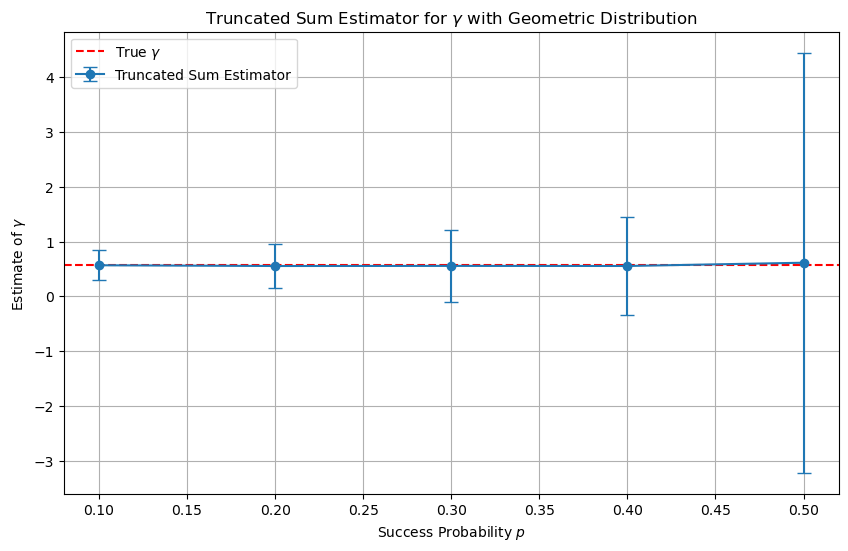

True value of γ: 0.5772156649015329
p = 0.10, Estimate = 0.567294, Std Error = 0.276617
p = 0.20, Estimate = 0.553719, Std Error = 0.397882
p = 0.30, Estimate = 0.555826, Std Error = 0.651851
p = 0.40, Estimate = 0.554270, Std Error = 0.900003
p = 0.50, Estimate = 0.613713, Std Error = 3.831956


In [21]:
# Function to compute a_k
def a_k(k):
    return (1 / k) - np.log(1 + 1 / k)

# Truncated sum estimator for gamma
def truncated_sum_estimator(p, num_samples):
    estimates = []
    for _ in range(num_samples):
        # Sample R from a geometric distribution
        R = np.random.geometric(p) - 1  # Subtract 1 to start from k=1
        # Compute the truncated sum
        gamma_hat = 0
        for k in range(1, R + 1):
            gamma_hat += a_k(k) / ((1 - p) ** k)
        estimates.append(gamma_hat)
    return np.mean(estimates), np.std(estimates)

# Parameters for the experiment
p_values = [0.1, 0.2, 0.3, 0.4, 0.5]  # Success probabilities for geometric distribution
num_samples = 10000  # Number of samples for each p

# Store results
results = {'p': [], 'estimates': [], 'std_errors': []}

# Run experiments
for p in p_values:
    mean_estimate, std_error = truncated_sum_estimator(p, num_samples)
    results['p'].append(p)
    results['estimates'].append(mean_estimate)
    results['std_errors'].append(std_error)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.errorbar(results['p'], results['estimates'], yerr=results['std_errors'],
             fmt='o-', capsize=5, label='Truncated Sum Estimator')
plt.axhline(true_gamma, color='r', linestyle='--', label=r'True $\gamma$')
plt.xlabel('Success Probability $p$')
plt.ylabel(r'Estimate of $\gamma$')
plt.title(r'Truncated Sum Estimator for $\gamma$ with Geometric Distribution')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("True value of γ:", true_gamma)
for i, p in enumerate(results['p']):
    print(f"p = {p:.2f}, Estimate = {results['estimates'][i]:.6f}, Std Error = {results['std_errors'][i]:.6f}")

### Interpretations


In this experiment, we used a truncated sum estimator to estimate Euler's constant $\gamma$ using a geometric distribution for the random variable R. The estimator is designed to have an expectation equal to the infinite $\sum_{k=0}{\infty} a_k$, where $a_k = \frac{1}{k} - \log(1 + \frac{1}{k})$. 

The estimates for $\gamma$ were close to the true value for lower values of the success probability $p$ (0.10 to 0.40), with estimates ranging from 0.5537 to 0.5673. However, as $p$ increased to 0.50, the estimate deviated significantly, reaching 0.6137. The standard errors also increased substantially with higher $p$, from 0.2766 at $p = 0.10$ to 3.8319 at $p = 0.50$, indicating greater variability in the estimates.

Lower values of $p$ resulted in more stable and accurate estimates with lower variability, while higher values of $p$ increased the variance, making the estimates less reliable. This highlights a trade-off between bias and variance, where lower $p$ values offer a better balance, providing more reliable estimates of gamma.

## Conclusion

Throughout the various simulations and methods employed to estimate Euler's constant $\gamma$, we observed several key findings:

1. **Monte Carlo Methods**:
   - **Standard Monte Carlo**: Provided estimates close to the true value of $\gamma \approx 0.5772$ but with relatively high standard errors, indicating significant variability.
   - **Stratified Monte Carlo**: Improved precision with lower standard errors compared to the standard method, demonstrating better stability in estimates.
   - **Quasi-Monte Carlo**: Consistently outperformed other methods, yielding estimates very close to the true value with exceptionally low standard errors, especially as sample sizes increased.
   - **Control Variate Monte Carlo**: Showed good accuracy but with slightly higher standard errors compared to Quasi-Monte Carlo, indicating more variability.

2. **Importance Sampling**:
   - The importance sampling estimator initially showed a systematic bias, with estimates stabilizing around 0.2704 instead of the true value. This bias suggests an issue with the importance function or sampling method, leading to inaccurate results despite low standard errors.

3. **Truncated Sum Estimator**:
   - The truncated sum estimator using a geometric distribution for $R$ provided unbiased estimates of $\gamma$. Lower values of the success probability $p$ (e.g., 0.10 to 0.30) yielded more stable and accurate estimates with lower variability.
   - Higher values of $p$ increased the variance significantly, making the estimates less reliable. This highlights a trade-off between bias and variance, where lower $p$ values offer a better balance.

The most reliable and accurate estimates of Euler's constant $\gamma$ were obtained using the Quasi-Monte Carlo method and the truncated sum estimator with lower values of $p$. These methods demonstrated a good balance between bias and variance, providing estimates close to the true value with minimal variability.

- **Quasi-Monte Carlo**: This method is highly effective for estimating $\gamma$ due to its ability to reduce standard errors significantly, especially with larger sample sizes.
- **Truncated Sum Estimator**: With an appropriate choice of $p$, this method can provide unbiased and stable estimates of $\gamma$.

For future estimations, it is recommended to use the Quasi-Monte Carlo method or the truncated sum estimator with a carefully chosen $p$ to achieve accurate and reliable results. These methods have shown robust performance in approximating Euler's constant $\gamma$.